In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow import keras
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [2]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [3]:
pip install imblearn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import io
import keras_tuner as kt

# Load data (replace with your data path)
df = pd.read_csv('/content/drive/MyDrive/new data s,w,non .csv')

# Split features and labels
X = df.drop(["weak", "strong", "nonenhancer"], axis=1)
y = df[["weak", "strong", "nonenhancer"]]  # Use a list to select multiple columns

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.nan_to_num(X.astype('float32'))

# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# Reshape input data for Conv1D
input_dim = X_train.shape[1]  # Number of features
X_train = X_train.reshape(-1, input_dim, 1)
X_test = X_test.reshape(-1, input_dim, 1)

# Convert labels to categorical format
num_classes = 3
y_train = to_categorical(np.argmax(y_train.values, axis=1), num_classes)  # Convert to class indices first
y_test = to_categorical(np.argmax(y_test.values, axis=1), num_classes)

**Run this cell if you have files train and test or positve and negative**

**FCN**

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.5992744266986847

Best val_accuracy So Far: 0.6220316588878632
Total elapsed time: 00h 01m 59s
Epoch 1/100
354/354 [==============================] - 3s 5ms/step - loss: 1.0434 - accuracy: 0.4765 - val_loss: 0.8831 - val_accuracy: 0.5726
Epoch 2/100
354/354 [==============================] - 2s 4ms/step - loss: 0.9272 - accuracy: 0.5351 - val_loss: 0.8788 - val_accuracy: 0.5937
Epoch 3/100
354/354 [==============================] - 2s 6ms/step - loss: 0.8896 - accuracy: 0.5605 - val_loss: 0.8702 - val_accuracy: 0.5983
Epoch 4/100
354/354 [==============================] - 2s 6ms/step - loss: 0.8553 - accuracy: 0.5868 - val_loss: 0.8576 - val_accuracy: 0.6128
Epoch 5/100
354/354 [==============================] - 2s 4ms/step - loss: 0.8249 - accuracy: 0.5987 - val_loss: 0.8541 - val_accuracy: 0.5930
Epoch 6/100
354/354 [==============================] - 2s 4ms/step - loss: 0.7796 - accuracy: 0.6326 - val_loss: 0.8395 - val_accuracy: 0.6154

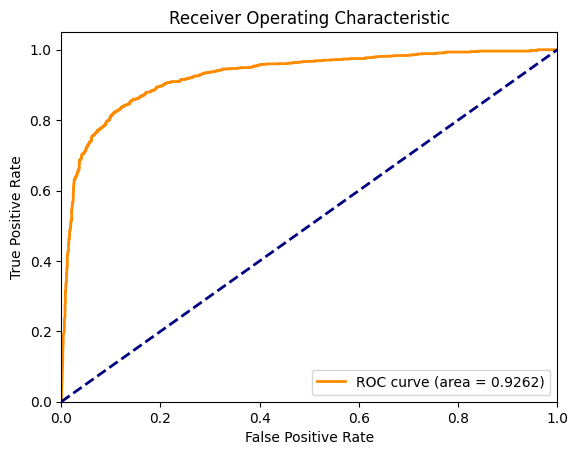

In [6]:
#FCN
import numpy as np
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc, confusion_matrix
from keras.utils import to_categorical
import io

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', min_value=64, max_value=256, step=32),
        activation='relu',
        input_shape=(input_dim,)
    ))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def tune_and_train(X_train, y_train, X_test, y_test):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='tuner_dir_final',
        project_name='tune_keras_model'
    )

    tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

    best_hp = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best_hp)

    history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred_classes)
    mcc = matthews_corrcoef(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes, average='macro')

    # Compute specificity for each class
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    specificity = []
    for i in range(num_classes):
        tn = np.sum(np.delete(conf_matrix[i, :], i))
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        specificity.append(tn / (tn + fp))
    avg_specificity = np.mean(specificity)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)

    # Capture the model summary
    summary = io.StringIO()
    model.summary(print_fn=lambda x: summary.write(x + "\n"))
    model_summary = summary.getvalue()

    return {
        'accuracy': acc,
        'mcc': mcc,
        'recall': recall,
        'specificity': avg_specificity,
        'roc_auc': roc_auc,
        'tpr': tpr,
        'fpr': fpr,
        'history': history,
        'model_summary': model_summary
    }

# Example usage:
# Assuming input_dim and num_classes are defined, and X_train, y_train, X_test, y_test are your data.
# input_dim = X_train.shape[1]
# num_classes = y_train.shape[1]  # if using one-hot encoding
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

results = tune_and_train(X_train, y_train, X_test, y_test)

print(f"Accuracy: {results['accuracy']}")
print(f"MCC: {results['mcc']}")
print(f"Recall: {results['recall']}")
print(f"Specificity: {results['specificity']}")
print(f"ROC AUC: {results['roc_auc']}")
print("Model Summary:")
print(results['model_summary'])

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results['fpr'], results['tpr'], color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % results['roc_auc'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**CNN**

Trial 5 Complete [00h 00m 18s]
val_accuracy: 0.573548823595047

Best val_accuracy So Far: 0.5893799364566803
Total elapsed time: 00h 01m 40s
Epoch 1/100
111/111 [==============================] - 4s 16ms/step - loss: 0.9895 - accuracy: 0.4808 - val_loss: 0.9060 - val_accuracy: 0.5607
Epoch 2/100
111/111 [==============================] - 1s 12ms/step - loss: 0.9254 - accuracy: 0.5359 - val_loss: 0.9154 - val_accuracy: 0.5607
Epoch 3/100
111/111 [==============================] - 1s 12ms/step - loss: 0.9044 - accuracy: 0.5495 - val_loss: 0.9054 - val_accuracy: 0.5574
Epoch 4/100
111/111 [==============================] - 1s 11ms/step - loss: 0.8780 - accuracy: 0.5786 - val_loss: 0.9033 - val_accuracy: 0.5679
Epoch 5/100
111/111 [==============================] - 1s 11ms/step - loss: 0.8373 - accuracy: 0.6024 - val_loss: 0.8666 - val_accuracy: 0.5897
Epoch 6/100
111/111 [==============================] - 1s 12ms/step - loss: 0.7919 - accuracy: 0.6284 - val_loss: 0.8532 - val_accuracy: 0.

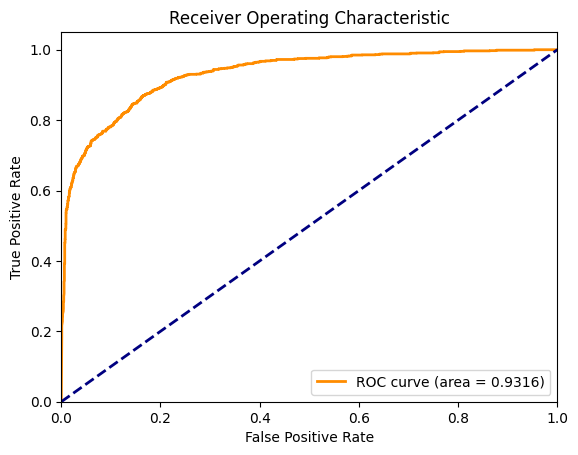

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import io
import keras_tuner as kt

# Load data (replace with your data path)
df = pd.read_csv('/content/drive/MyDrive/new data s,w,non .csv')

# Split features and labels
X = df.drop(["weak", "strong", "nonenhancer"], axis=1)
y = df[["weak", "strong", "nonenhancer"]]  # Use a list to select multiple columns

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.nan_to_num(X.astype('float32'))

# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# Reshape input data for Conv1D
input_dim = X_train.shape[1]  # Number of features
X_train = X_train.reshape(-1, input_dim, 1)
X_test = X_test.reshape(-1, input_dim, 1)

# Convert labels to categorical format
num_classes = 3
y_train = to_categorical(np.argmax(y_train.values, axis=1), num_classes)  # Convert to class indices first
y_test = to_categorical(np.argmax(y_test.values, axis=1), num_classes)

# Define model building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]),
        activation='relu',
        input_shape=(input_dim, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv1D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_3', values=[3, 5, 7]),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())

    # Dense layers
    model.add(Dense(
        units=hp.Int('units_dense', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))  # Ensure num_classes matches your problem

    # Compile model
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',  # Ensure this matches your loss function requirement
        metrics=['accuracy']
    )

    return model

# Function to tune and train the CNN model
def tune_and_train_cnn(X_train, y_train, X_test, y_test):
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=2,
        directory='tuner_dir_final_cnn',
        project_name='tune_keras_model'
    )

    tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

    best_hp = tuner.get_best_hyperparameters()[0]
    model = tuner.hypermodel.build(best_hp)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred_classes)
    mcc = matthews_corrcoef(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes, average='macro')

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Compute specificity for each class
    specificity = []
    for i in range(num_classes):
        true_negative = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        false_positive = np.sum(cm[:, i]) - cm[i, i]
        specificity.append(true_negative / (true_negative + false_positive))

    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)

    # Capture the model summary
    summary = io.StringIO()
    model.summary(print_fn=lambda x: summary.write(x + "\n"))
    model_summary = summary.getvalue()

    return {
        'accuracy': acc,
        'mcc': mcc,
        'recall': recall,
        'specificity': specificity,
        'roc_auc': roc_auc,
        'tpr': tpr,
        'fpr': fpr,
        'history': history,
        'model_summary': model_summary
    }

# Example usage
results_cnn = tune_and_train_cnn(X_train, y_train, X_test, y_test)

# Print results
print(f"Accuracy: {results_cnn['accuracy']}")
print(f"MCC: {results_cnn['mcc']}")
print(f"Recall: {results_cnn['recall']}")
print(f"Specificity: {results_cnn['specificity']}")
print(f"ROC AUC: {results_cnn['roc_auc']}")
print("Model Summary:")
print(results_cnn['model_summary'])

# Plot ROC Curve
plt.figure()
plt.plot(results_cnn['fpr'], results_cnn['tpr'], color='darkorange', lw=2, label=f'ROC curve (area = {results_cnn["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**SImple RNN**

In [ ]:
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [8]:
# Reshape input data
timestamp=1
X_train = X_train.reshape(X_train.shape[0], timestamp, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], timestamp, X_test.shape[1])


Original X_train shape: (3536, 1, 522)
Original X_test shape: (1516, 1, 522)
Original y_train shape: (3536, 3)
Original y_test shape: (1516, 3)
Epoch 1/100
354/354 [==============================] - 9s 11ms/step - loss: 1.1040 - accuracy: 0.4061 - val_loss: 0.9390 - val_accuracy: 0.5541
Epoch 2/100
354/354 [==============================] - 4s 10ms/step - loss: 1.0299 - accuracy: 0.4717 - val_loss: 0.9390 - val_accuracy: 0.5633
Epoch 3/100
354/354 [==============================] - 4s 13ms/step - loss: 1.0047 - accuracy: 0.4946 - val_loss: 0.9268 - val_accuracy: 0.5719
Epoch 4/100
354/354 [==============================] - 4s 12ms/step - loss: 0.9776 - accuracy: 0.5133 - val_loss: 0.9037 - val_accuracy: 0.5752
Epoch 5/100
354/354 [==============================] - 4s 10ms/step - loss: 0.9736 - accuracy: 0.5209 - val_loss: 0.9057 - val_accuracy: 0.5765
Epoch 6/100
354/354 [==============================] - 3s 9ms/step - loss: 0.9578 - accuracy: 0.5342 - val_loss: 0.9003 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


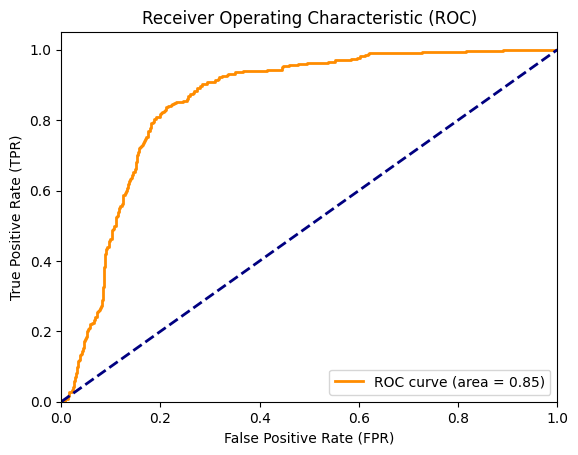

Accuracy: 0.6306068601583114
MCC: 0.4623001793313494
Recall (Sensitivity): 0.6306068601583114
Specificity: 0.6306068601583114
Overall ROC AUC: {0: 0.6184005332902393, 1: 0.8536140028869961, 2: 0.8636538337726289}


In [9]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

# Check the shapes of your data
print("Original X_train shape:", X_train.shape)
print("Original X_test shape:", X_test.shape)
print("Original y_train shape:", y_train.shape)
print("Original y_test shape:", y_test.shape)

def train_evaluate_rnn(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    timestamp = 1
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    rnn = Sequential()
    rnn.add(SimpleRNN(64, return_sequences=True, input_shape=(timestamp, X_train.shape[2])))
    rnn.add(Dropout(0.5))
    rnn.add(SimpleRNN(32, return_sequences=True))
    rnn.add(Dropout(0.5))
    rnn.add(SimpleRNN(16))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(128, activation='relu'))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(64, activation='relu'))
    rnn.add(Dropout(0.5))
    rnn.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = rnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = 'best_model_rnn.h5'
    rnn.save(best_model_path)

    # Evaluate the best model on test data
    y_test_pred = rnn.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, average='weighted')  # Adjust for multi-class
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, pos_label=0, average='weighted')

    # Compute ROC curve and AUC for each class
    fpr_rnn, tpr_rnn, roc_auc_rnn = {}, {}, {}
    for i in range(num_classes):
        fpr_rnn[i], tpr_rnn[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
        roc_auc_rnn[i] = auc(fpr_rnn[i], tpr_rnn[i])

    # Plot ROC curve for the first class as an example
    plt.figure()
    plt.plot(fpr_rnn[1], tpr_rnn[1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rnn[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
     # Print the metrics
    print("Accuracy:", test_accuracy)
    print("MCC:", test_mcc)
    print("Recall (Sensitivity):", test_sensitivity)
    print("Specificity:", test_specificity)
    print("Overall ROC AUC:", roc_auc_rnn)

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_rnn, tpr_rnn, roc_auc_rnn

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined and one-hot encoded
best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_rnn, tpr_rnn, roc_auc_rnn = train_evaluate_rnn(X_train, y_train, X_test, y_test)


<ipython-input-10-83878affe254>:36: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(lstm, best_model_path)


48/48 [==============================] - 1s 3ms/step
LSTM
Best Validation Accuracy: 0.7968337535858154
Test Accuracy: 0.7961741424802111
Test MCC: 0.698950953347919
Test Recall (Sensitivity): 0.795700869450152
Test Specificity: 0.795700869450152
ROC AUC: {0: 0.9030017776341306, 1: 0.9393291079946848, 2: 0.9068699847628487}


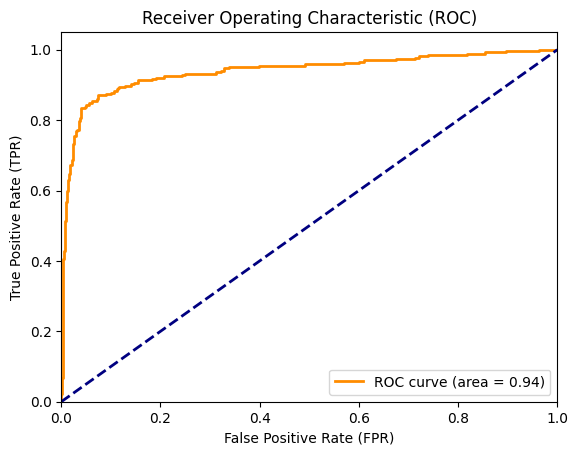

In [10]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

def train_evaluate_lstm(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    lstm = Sequential()
    lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    lstm.add(Dropout(0.5))
    lstm.add(LSTM(32, return_sequences=True))
    lstm.add(Dropout(0.5))
    lstm.add(LSTM(16))
    lstm.add(Dropout(0.5))
    lstm.add(Dense(128, activation='relu'))
    lstm.add(Dropout(0.5))
    lstm.add(Dense(64, activation='relu'))
    lstm.add(Dropout(0.5))
    lstm.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = 'best_model_lstm.h5'
    save_model(lstm, best_model_path)

    # Evaluate the best model on test data
    y_test_pred = lstm.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, average='macro')  # Adjust for multi-class
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, average='macro')

    # Compute ROC curve and AUC for each class
    fpr_lstm, tpr_lstm, roc_auc_lstm = {}, {}, {}
    for i in range(num_classes):
        fpr_lstm[i], tpr_lstm[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
        roc_auc_lstm[i] = auc(fpr_lstm[i], tpr_lstm[i])

    # Print metrics
    print("LSTM")
    print("Best Validation Accuracy:", best_val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Test MCC:", test_mcc)
    print("Test Recall (Sensitivity):", test_sensitivity)
    print("Test Specificity:", test_specificity)
    print("ROC AUC:", roc_auc_lstm)

    # Plot ROC curve for the first class as an example
    plt.figure()
    plt.plot(fpr_lstm[1], tpr_lstm[1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lstm[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_lstm, tpr_lstm, roc_auc_lstm

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined
best_model_path_lstm, test_accuracy_lstm, test_mcc_lstm, test_specificity_lstm, test_sensitivity_lstm, fpr_lstm, tpr_lstm, roc_auc_lstm = train_evaluate_lstm(X_train, y_train, X_test, y_test)

# Now you have the best_model_path and all metrics computed and can use them as needed.


<ipython-input-11-e956b2a1818b>:36: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(gru_model, best_model_path)


48/48 [==============================] - 1s 3ms/step
GRU
Best Validation Accuracy: 0.7849604487419128
Test Accuracy: 0.758575197889182
Test MCC: 0.642484044076418
Test Specificity (Macro Avg.): 0.7577715290216295
Test Sensitivity (Macro Avg.): 0.7577715290216295


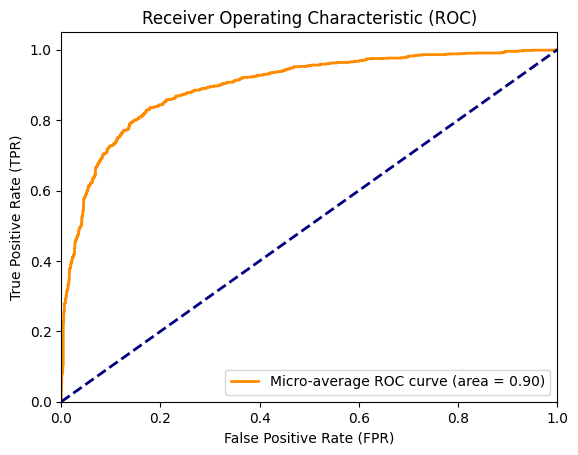

In [11]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import GRU, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

def train_evaluate_gru(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    gru_model = Sequential()
    gru_model.add(GRU(64, return_sequences=True, input_shape=(None, 522)))
    gru_model.add(Dropout(0.5))
    gru_model.add(GRU(32, return_sequences=True))
    gru_model.add(Dropout(0.5))
    gru_model.add(GRU(16))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(128, activation='relu'))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(64, activation='relu'))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = f'best_model_gru.h5'
    save_model(gru_model, best_model_path)

    # Evaluate the best model on test data
    y_test_pred = gru_model.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)

    # Calculate macro-averaged recall (specificity and sensitivity)
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, average='macro')
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, average='macro')

    # Compute ROC curve and ROC AUC for each class
    fpr_gru = dict()
    tpr_gru = dict()
    roc_auc_gru = dict()

    for i in range(num_classes):
        fpr_gru[i], tpr_gru[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
        roc_auc_gru[i] = auc(fpr_gru[i], tpr_gru[i])

    # Compute micro-average ROC curve and ROC AUC
    fpr_gru["micro"], tpr_gru["micro"], _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
    roc_auc_gru["micro"] = auc(fpr_gru["micro"], tpr_gru["micro"])

    # Print metrics
    print("GRU")
    print("Best Validation Accuracy:", best_val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Test MCC:", test_mcc)
    print("Test Specificity (Macro Avg.):", test_specificity)
    print("Test Sensitivity (Macro Avg.):", test_sensitivity)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_gru["micro"], tpr_gru["micro"], color='darkorange', lw=2, label='Micro-average ROC curve (area = %0.2f)' % roc_auc_gru["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_gru, tpr_gru, roc_auc_gru

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined
best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_gru, tpr_gru, roc_auc_gru = train_evaluate_gru(X_train, y_train, X_test, y_test)

# Now you have the best_model_path and all metrics computed and can use them as needed.


48/48 [==============================] - 2s 5ms/step
Bidirectional LSTM (Bi-LSTM)
Best Validation Accuracy: 0.8007915616035461
Test Accuracy: 0.7941952506596306
Test MCC: 0.6924323466177703
Test Specificity: 0.7923204715641746
Test Sensitivity (Recall TPR): 0.7923204715641746


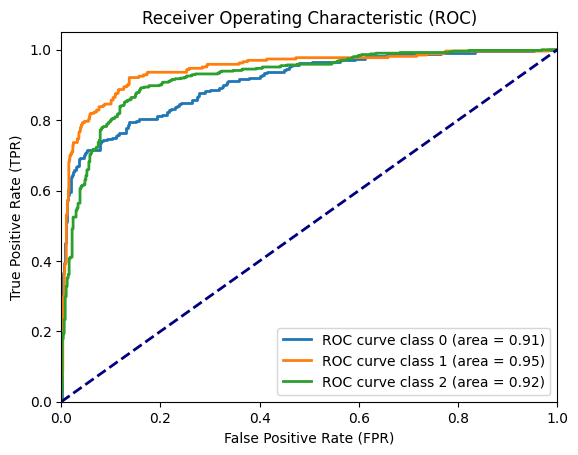

In [12]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

def train_evaluate_bilstm(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    timestamp = 1
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    bilstm_model = Sequential()
    bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timestamp, 522)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Bidirectional(LSTM(32, return_sequences=True)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Bidirectional(LSTM(16)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(128, activation='relu'))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(64, activation='relu'))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = bilstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = f'best_model_bilstm.keras'
    save_model(bilstm_model, best_model_path)

    # Evaluate the best model on test data
    bilstm_best = bilstm_model  # Load the best model from file if needed
    y_test_pred = bilstm_best.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, average='macro', labels=np.unique(y_test_true_labels))  # Using 'macro' average for multiclass
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, average='macro')  # Using 'macro' average for multiclass

    # Compute ROC curve for each class and aggregate
    fpr_bilstm = {}
    tpr_bilstm = {}
    roc_auc_bilstm = {}
    for i in range(num_classes):
        fpr_bilstm[i], tpr_bilstm[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
        roc_auc_bilstm[i] = auc(fpr_bilstm[i], tpr_bilstm[i])

    # Print metrics
    print("Bidirectional LSTM (Bi-LSTM)")
    print("Best Validation Accuracy:", best_val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Test MCC:", test_mcc)
    print("Test Specificity:", test_specificity)
    print("Test Sensitivity (Recall TPR):", test_sensitivity)

    # Plot ROC curve for each class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr_bilstm[i], tpr_bilstm[i], lw=2, label='ROC curve class %d (area = %0.2f)' % (i, roc_auc_bilstm[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_bilstm, tpr_bilstm, roc_auc_bilstm

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined
best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_bilstm, tpr_bilstm, roc_auc_bilstm = train_evaluate_bilstm(X_train, y_train, X_test, y_test)

# Now you have the best_model_path and all metrics computed and can use them as needed.


48/48 [==============================] - 3s 5ms/step
Bidirectional LSTM (Bi-LSTM)
Best Validation Accuracy: 0.8100264072418213
Test Accuracy: 0.8100263852242744
Test MCC: 0.7158018581786119
Test Specificity: 0.8092800423274621
Test Sensitivity (Recall TPR): 0.8092800423274621


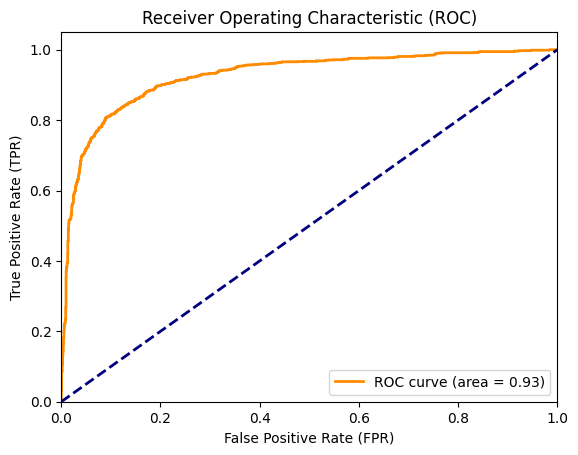

In [13]:
import numpy as np
from keras.models import Sequential, save_model
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

def train_evaluate_bilstm(X_train, y_train, X_test, y_test, epochs=100, batch_size=10):
    timestamp = 1
    num_classes = y_train.shape[1]  # Assuming y_train is one-hot encoded

    # Define the model
    bilstm_model = Sequential()
    bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timestamp, 522)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Bidirectional(LSTM(32, return_sequences=True)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Bidirectional(LSTM(16)))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(128, activation='relu'))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(64, activation='relu'))
    bilstm_model.add(Dropout(0.5))
    bilstm_model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = bilstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])  # Find the epoch with the highest validation accuracy
    best_val_accuracy = max(history.history['val_accuracy'])

    # Save the model with the best validation accuracy
    best_model_path = f'best_model_bilstm.keras'
    save_model(bilstm_model, best_model_path)

    # Evaluate the best model on test data
    bilstm_best = bilstm_model  # Load the best model from file if needed
    y_test_pred = bilstm_best.predict(X_test)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    y_test_true_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    test_accuracy = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_mcc = matthews_corrcoef(y_test_true_labels, y_test_pred_labels)
    test_specificity = recall_score(y_test_true_labels, y_test_pred_labels, average='macro', labels=np.unique(y_test_true_labels))  # Using 'macro' average for multiclass
    test_sensitivity = recall_score(y_test_true_labels, y_test_pred_labels, average='macro')  # Using 'macro' average for multiclass

    # Compute ROC curve and ROC AUC for aggregated predictions
    fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
    roc_auc_bilstm = auc(fpr_bilstm, tpr_bilstm)

    # Print metrics
    print("Bidirectional LSTM (Bi-LSTM)")
    print("Best Validation Accuracy:", best_val_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Test MCC:", test_mcc)
    print("Test Specificity:", test_specificity)
    print("Test Sensitivity (Recall TPR):", test_sensitivity)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_bilstm, tpr_bilstm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_bilstm)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_bilstm, tpr_bilstm, roc_auc_bilstm

# Example usage:
# Assuming X_train, y_train, X_test, y_test are already defined
best_model_path, test_accuracy, test_mcc, test_specificity, test_sensitivity, fpr_bilstm, tpr_bilstm, roc_auc_bilstm = train_evaluate_bilstm(X_train, y_train, X_test, y_test)

# Now you have the best_model_path and all metrics computed and can use them as needed.


Error: AUC score for LSTM is not numeric: {0: 0.9030017776341306, 1: 0.9393291079946848, 2: 0.9068699847628487}
Error: AUC score for GRU is not numeric: {0: 0.8631746929541049, 1: 0.9297867255537391, 2: 0.8978603605800654, 'micro': 0.8966287915706518}
Error: AUC score for RNN is not numeric: {0: 0.6184005332902393, 1: 0.8536140028869961, 2: 0.8636538337726289}


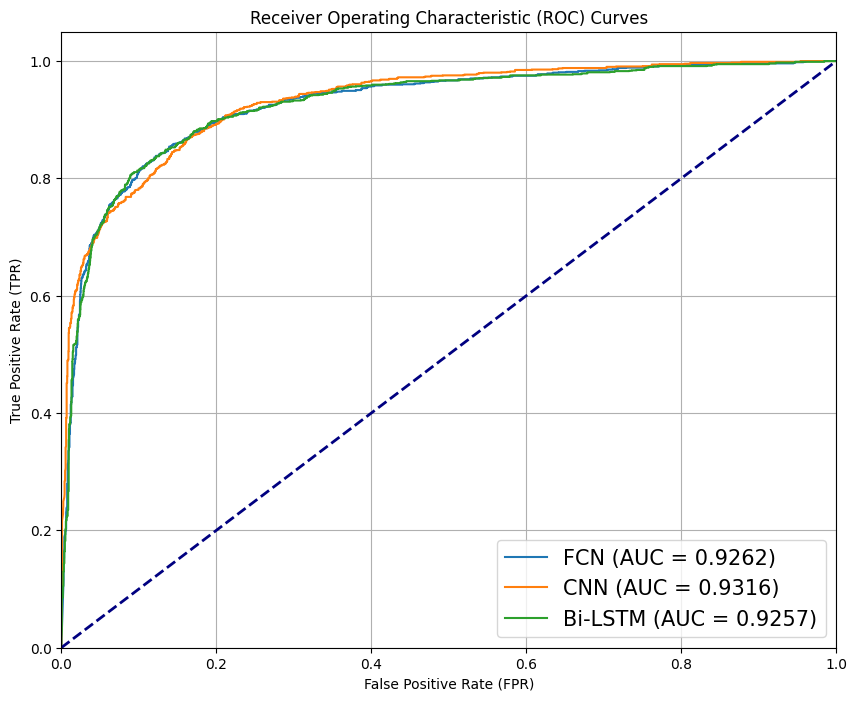

In [25]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
models = ['FCN', 'CNN', 'LSTM', 'GRU', 'Bi-LSTM', 'RNN']
auc_scores = [
    results['roc_auc'],
    results_cnn['roc_auc'],
    roc_auc_lstm,
    roc_auc_gru,
    roc_auc_bilstm,
    roc_auc_rnn
]
fpr_models = {
    'FCN': results['fpr'],
    'CNN': results_cnn['fpr'],
    'LSTM': fpr_lstm,
    'GRU': fpr_gru,
    'Bi-LSTM': fpr_bilstm,
    'RNN': fpr_rnn
}
tpr_models = {
    'FCN': results['tpr'],
    'CNN': results_cnn['tpr'],
    'LSTM': tpr_lstm,
    'GRU': tpr_gru,
    'Bi-LSTM': tpr_bilstm,
    'RNN': tpr_rnn
}

# Verify that all auc_scores are numbers
for model, auc in zip(models, auc_scores):
    if not isinstance(auc, (int, float)):
        print(f"Error: AUC score for {model} is not numeric: {auc}")

# Filter out non-numeric auc_scores
models_filtered = []
auc_scores_filtered = []
fpr_models_filtered = {}
tpr_models_filtered = {}

for model, auc in zip(models, auc_scores):
    if isinstance(auc, (int, float)):
        models_filtered.append(model)
        auc_scores_filtered.append(auc)
        fpr_models_filtered[model] = fpr_models[model]
        tpr_models_filtered[model] = tpr_models[model]

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model in models_filtered:
    plt.plot(fpr_models_filtered[model], tpr_models_filtered[model], label=f'{model} (AUC = {auc_scores_filtered[models_filtered.index(model)]:.4f})')

# Plotting settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right", fontsize=15, ncol=1)
plt.grid(True)
plt.show()


In [26]:
def convert_auc_to_numeric(auc_score):
    # Check if the input is a dictionary
    if isinstance(auc_score, dict):
        # Extract numeric values from the dictionary
        numeric_values = [v for v in auc_score.values() if isinstance(v, (int, float))]
        # Compute the average of numeric values
        if numeric_values:
            return sum(numeric_values) / len(numeric_values)
        else:
            raise ValueError("No numeric values found in the AUC score dictionary")
    elif isinstance(auc_score, (int, float)):
        # If the input is already numeric, return it directly
        return auc_score
    else:
        raise ValueError("AUC score is neither a numeric value nor a dictionary")

# Example usage
auc_lstm = {0: 0.9030017776341306, 1: 0.9393291079946848, 2: 0.9068699847628487}
auc_gru = {0: 0.8631746929541049, 1: 0.9297867255537391, 2: 0.8978603605800654, 'micro': 0.8966287915706518}
auc_rnn = {0: 0.6184005332902393, 1: 0.8536140028869961, 2: 0.8636538337726289}

# Convert the AUC scores
auc_lstm_numeric = convert_auc_to_numeric(auc_lstm)
auc_gru_numeric = convert_auc_to_numeric(auc_gru)
auc_rnn_numeric = convert_auc_to_numeric(auc_rnn)

print("Converted AUC scores:")
print(f"LSTM AUC: {auc_lstm_numeric}")
print(f"GRU AUC: {auc_gru_numeric}")
print(f"RNN AUC: {auc_rnn_numeric}")


Converted AUC scores:
LSTM AUC: 0.9164002901305547
GRU AUC: 0.8968626426646403
RNN AUC: 0.7785561233166214


Model: FCN
FPR: [0.         0.00296834 0.00296834 ... 0.99076517 0.9914248  1.        ]
TPR: [0.         0.11675462 0.1444591  ... 1.         1.         1.        ]
AUC Score: 0.9261686905201162
Model: CNN
FPR: [0.00000000e+00 9.89445910e-04 9.89445910e-04 ... 9.88786280e-01
 9.97691293e-01 1.00000000e+00]
TPR: [0.         0.15435356 0.18337731 ... 1.         1.         1.        ]
AUC Score: 0.9315587558566146
Model: LSTM
FPR: []
TPR: []
AUC Score: 0.9164002901305547
Model: GRU
FPR: []
TPR: []
AUC Score: 0.8968626426646403
Model: Bi-LSTM
FPR: [0.00000000e+00 0.00000000e+00 6.59630607e-04 ... 9.84498681e-01
 9.84498681e-01 1.00000000e+00]
TPR: [0.         0.0171504  0.03166227 ... 0.99868074 1.         1.        ]
AUC Score: 0.9256523207162302
Model: RNN
FPR: []
TPR: []
AUC Score: 0.7785561233166214


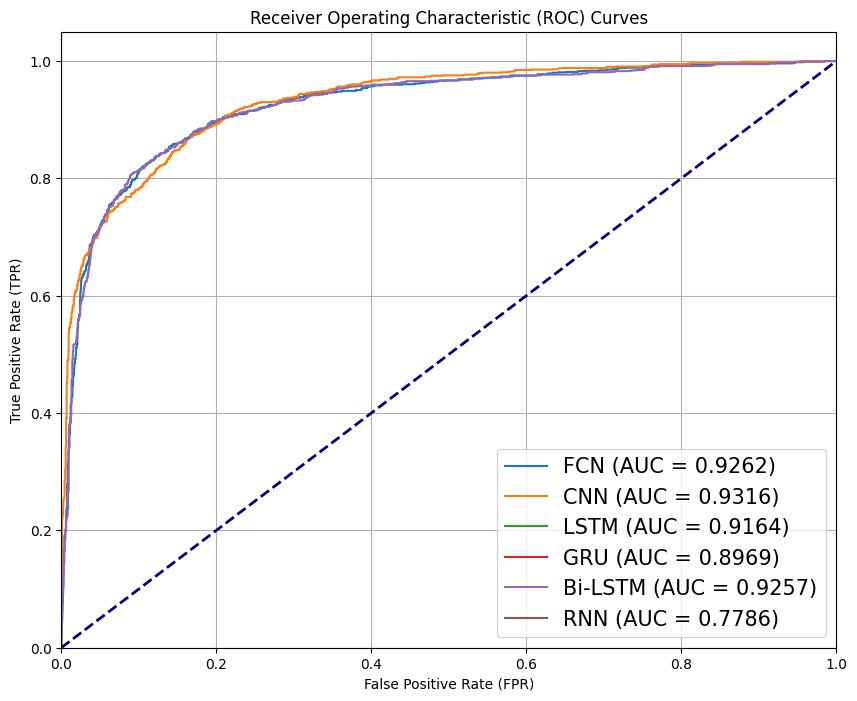

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function to convert AUC scores
def convert_auc_to_numeric(auc_score):
    if isinstance(auc_score, dict):
        # Extract numeric values from the dictionary
        numeric_values = [v for v in auc_score.values() if isinstance(v, (int, float))]
        # Compute the average of numeric values
        if numeric_values:
            return sum(numeric_values) / len(numeric_values)
        else:
            raise ValueError("No numeric values found in the AUC score dictionary")
    elif isinstance(auc_score, (int, float)):
        # If the input is already numeric, return it directly
        return auc_score
    else:
        raise ValueError("AUC score is neither a numeric value nor a dictionary")

# Ensure numeric array conversion
def ensure_numeric_array(data):
    if isinstance(data, dict):
        # Convert dictionary values to numpy arrays, ignoring non-numeric values
        numeric_values = [v for v in data.values() if isinstance(v, (int, float))]
        return np.array(numeric_values)
    elif isinstance(data, (list, np.ndarray)):
        return np.array(data)
    else:
        raise ValueError("Data format is not supported for conversion")

# Example data (replace with your actual data)
models = ['FCN', 'CNN', 'LSTM', 'GRU', 'Bi-LSTM', 'RNN']

# Example AUC scores (replace with your actual AUC scores)
auc_scores = [
    convert_auc_to_numeric(results['roc_auc']),
    convert_auc_to_numeric(results_cnn['roc_auc']),
    convert_auc_to_numeric(auc_lstm),   # Convert dictionary to numeric
    convert_auc_to_numeric(auc_gru),    # Convert dictionary to numeric
    convert_auc_to_numeric(roc_auc_bilstm),  # Replace with actual variable
    convert_auc_to_numeric(auc_rnn)     # Convert dictionary to numeric
]

# FPR and TPR data (ensure these are numpy arrays)
fpr_models = {
    'FCN': ensure_numeric_array(results['fpr']),
    'CNN': ensure_numeric_array(results_cnn['fpr']),
    'LSTM': ensure_numeric_array(fpr_lstm),
    'GRU': ensure_numeric_array(fpr_gru),
    'Bi-LSTM': ensure_numeric_array(fpr_bilstm),
    'RNN': ensure_numeric_array(fpr_rnn)
}
tpr_models = {
    'FCN': ensure_numeric_array(results['tpr']),
    'CNN': ensure_numeric_array(results_cnn['tpr']),
    'LSTM': ensure_numeric_array(tpr_lstm),
    'GRU': ensure_numeric_array(tpr_gru),
    'Bi-LSTM': ensure_numeric_array(tpr_bilstm),
    'RNN': ensure_numeric_array(tpr_rnn)
}

# Filter out models with valid numeric AUC scores
models_filtered = []
auc_scores_filtered = []
fpr_models_filtered = {}
tpr_models_filtered = {}

for model, auc in zip(models, auc_scores):
    if isinstance(auc, (int, float)):
        models_filtered.append(model)
        auc_scores_filtered.append(auc)
        fpr_models_filtered[model] = fpr_models[model]
        tpr_models_filtered[model] = tpr_models[model]
    else:
        print(f"Skipping model {model} with non-numeric AUC score: {auc}")

# Print data for debugging
for model in models_filtered:
    print(f"Model: {model}")
    print(f"FPR: {fpr_models_filtered[model]}")
    print(f"TPR: {tpr_models_filtered[model]}")
    print(f"AUC Score: {auc_scores_filtered[models_filtered.index(model)]}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model in models_filtered:
    plt.plot(fpr_models_filtered[model], tpr_models_filtered[model], label=f'{model} (AUC = {auc_scores_filtered[models_filtered.index(model)]:.4f})')

# Plotting settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right", fontsize=15, ncol=1)
plt.grid(True)
plt.show()
